## Appendix G 

Toronto Airbnb Pricing Analysis Code

**Steps performed:**

+ 1. Data Preprocessing
    + 1.1 Removing unnecessary columns for modeling
    + 1.2 Removing variables with significant null values
    + 1.3 Removing columns that have the same information
    + 1.4 Handling missing values (median-set, zero-set or mean-seat) and Data Engineering
    
    
+ 2. Exploratory Data Analysis
    + 2.1 Seasonal Demand
    + 2.2 Price Analysis
    + 2.3 Geographical Analysis
    + 2.4 Correlation
    
 
+ 3. Modeling
    + 3.1 Estimating test sample size
    + 3.2 Standardizing and Normalizing
    + 3.3 Splitting the data in training and testing
    + 3.4 Feature Selection
    + 3.5 Random Forest
    + 3.6 Gradient Boosting
    + 3.7 Final Model and Parameter Tuning
    + 3.8 Predictions on the test set

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from monthdelta import MonthDelta, monthmod
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd 
import json
from pandas.io.json import json_normalize
import requests
import descartes
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

### 1. Data Preprocessing

In [2]:
airbnb = pd.read_csv("listings2.csv")

#### 1.1 Removing unnecessary columns for modeling

Natural Language Preprocessing is not going to be performed. Hence, free text columns will be dropped and columns that are not useful for predicting the price. (id, listing_url. scrape_id, name, summary)

In [3]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
airbnb.drop(cols_to_drop, axis=1, inplace=True)

#### 1.2 Removing variables with significant null values

Columns with more than 80% of missing values will be dropped from the data the next code will plot the null values per variables

In [ ]:
plt.figure(figsize=(10,3))
na_col = airbnb.isnull().sum().sort_values(ascending=False)
len_col = airbnb.shape[0]
percent = na_col / len_col

col_val = []
tr = len(airbnb)
j=0
for i in na_col:
  if i/tr > 0.8:
    col_val.append("r")
    j +=1
  else:
    col_val.append("b")
#plt.figure(dpi=90)
percent.plot(kind='bar', color = tuple(col_val), fontsize=4)
plt.show
plt.title("Variables with significant Null Values")
plt.legend(["> 80% Null Values"], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize = 4)


#### 1.3 Removing columns that have the same information

Columns that represent the same information were dropped from the model for example host listing count and host total listing counts, except for one. Listing count columns that splot host listing counts into properties will be dropped.
Only availability of 30 days will stay due to Toronto regulations 

In [4]:
airbnb.loc[((airbnb.host_listings_count == airbnb.host_total_listings_count) == False)]
airbnb.drop(['neighbourhood_group_cleansed', 'square_feet', 
         'weekly_price', 'monthly_price', 'license', 'jurisdiction_names',
            'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
             'host_total_listings_count', 'calculated_host_listings_count', 
             'calculated_host_listings_count_entire_homes',
            'calendar_updated','availability_60', 'availability_90' ,'availability_365',
            'id', 'bed_type','host_acceptance_rate'], axis=1, inplace=True)

For the property location variables, only neighborhood cleansed was kept in the model. Also, all the locations are in Toronto, Ontario, Canada. Thus, city, state, and country were dropped. There are some columns for minimum and maximum nights, but only minimum nights and maximum nights were lept, because there are small differencse between maximum nigths and maximum maximum nights. In bed type, the majority of the values are real bed, there is no significance usecase of having this variable in the dataset.

In [5]:
airbnb.drop(['country', 'is_location_exact','zipcode', 'state', 'market',
         'latitude', 'longitude','street', 'neighbourhood', 'city',
         'smart_location', 'country_code'], axis=1, inplace=True)
sum((airbnb.maximum_nights == airbnb.maximum_maximum_nights) == False)
airbnb.drop(['maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
             'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights'], axis=1, inplace=True)

#### 1.4 Handling missing values (median-set, zero-set or mean-seat) and Data Engineering

In [6]:
airbnb.replace({'f': 0, 't': 1}, inplace=True)

Removing unbalanced categorical variables because they wont apport significant information to the model. 

In [7]:
airbnb.drop(['has_availability','host_has_profile_pic',
            'require_guest_phone_verification','require_guest_profile_picture',
            'requires_license', 'is_business_travel_ready', 'experiences_offered'],axis=1, inplace=True)

**host_response_time**

30% of the values of this variable are null vaulues we can consider this as unknown. The null values were replaced with **unkwown**

In [8]:
airbnb.host_response_time.isnull().sum()/len(airbnb)
airbnb.host_response_time.fillna('unknown', inplace=True)

**host_response_rate**

Converting this variable into a categorical feature. The new groups will be "0-49%", "50-89%", "90-99%", "100%" and "unknown" in case of missing values.

In [9]:
# Removing the % sign and converting into float
airbnb.host_response_rate = airbnb.host_response_rate.str.replace("%","").astype('float64')
# Regrouping
airbnb.host_response_rate = pd.cut(airbnb.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
airbnb.host_response_rate = airbnb.host_response_rate.astype('str')
# Replace nulls with 'unknown'
airbnb.host_response_rate.replace('nan', 'unknown', inplace=True)

**security_deposit**

Converting this variables into float. The null values mean that the security deposit is zero.

In [10]:
# Removing the dolar sign and ","
airbnb.security_deposit = airbnb.security_deposit.str.replace('$','')
airbnb.security_deposit = airbnb.security_deposit.str.replace(",", "")
# Filling null values with 0
airbnb.security_deposit.fillna(0, inplace=True)
# "Converting into float"
airbnb.security_deposit = airbnb.security_deposit.astype('float')

**Review rating columns**

Around 30% of the values of these variables are null values. The null values are probably due to the property does not have a review yet. This does not mean that we should replace the NA with zero. Thus, we transformed them in categorical variables with the following groups: "0-8/10", "9/10", "10/10" and "no reviews"


In [11]:
reviews_plot = list(airbnb.columns[airbnb.columns.str.startswith("review_scores") == True])

In [12]:
# Binning function
def bin_column(col, bins, labels, na_label='unknown'):
    airbnb[col] = pd.cut(airbnb[col], bins=bins, labels=labels, include_lowest=True)
    airbnb[col] = airbnb[col].astype('str')
    airbnb[col].replace('nan', na_label, inplace=True)

In [13]:
# elimitating the first variable because it is the only one that is out of 100
reviews_plot.pop(0)
# Binning for all columns scored out of 10
for col in reviews_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [14]:
# Categorizing the variable review_scores_rating
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

**reviews_per_month and number_of_reviews_ltm**

They were removed from the model because number of reviews is more important

In [15]:
airbnb.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

**first_review and last_review**

They contain 30% of missing values. These values indicated that the property does not have a review. New categorical variables were created using these variables (time since first review and time since last review). 

The groups were the following '0-6 months', '6-12 months', '1-2 years', '2-3 years', '4+ years' and no reviews.

After doing the EDA, last review and first review were dropped.

In [16]:
# first review
airbnb.first_review = pd.to_datetime(airbnb.first_review) # Converting to datetime
airbnb['time_since_first_review'] = (pd.datetime(2020, 2, 14) - airbnb.first_review).astype('timedelta64[D]')
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(airbnb.time_since_first_review)],
           labels=['0-6 months','6-12 months','1-2 years','2-3 years','4+ years'], na_label='no reviews')

In [17]:
# last review 
airbnb.last_review = pd.to_datetime(airbnb.last_review)
airbnb['time_since_last_review'] = (pd.datetime(2020, 2, 14) - airbnb.last_review).astype('timedelta64[D]')
# airbnb.time_since_last_review.hist(figsize=(15,5), bins=30);
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(airbnb.time_since_last_review)],
           labels=['0-2 weeks','2-8 weeks','2-6 months','6-12 months','1+ year'],na_label='no reviews')

In [18]:
# Dropping last review
airbnb.drop('last_review', axis=1, inplace=True)

**cleaning_fee**

Converting this variables into float. The null values mean that the security deposit is zero.

In [19]:
airbnb.cleaning_fee = airbnb.cleaning_fee.str.replace('$','')
airbnb.cleaning_fee = airbnb.cleaning_fee.str.replace(",", "")
airbnb.cleaning_fee.fillna(0, inplace=True)
airbnb.cleaning_fee = airbnb.cleaning_fee.astype('float')

**Beds, bedrooms and bathrooms**

Replacing the null values with the median

In [20]:
# Replacing null values with the median
for c in ['beds', 'bedrooms', 'bathrooms']:
    airbnb[c].fillna(airbnb[c].median(), inplace=True)

**host related columns**

The rows with null values will be removed, it represents less than 5% of the data.

In [21]:
airbnb.dropna(subset=['host_since'], inplace=True)

**property_type**

There are many categories in this variables. This we will group them into house, apartment and others. Otherwise, some categories wont be representative. 

In [22]:
 airbnb.property_type.value_counts()
# Creating a dictionary to replace the categories with house, apartment and others
prop_dic = {'Townhouse': 'House','Loft': 'Apartment','Serviced apartment': 'Apartment','Cottage': 'House','Villa': 'House','Bungalow': 'House','Tiny house': 'House','Dome house': 'House','Earth house': 'House','Chalet': 'House'}
airbnb.property_type.replace(prop_dic, inplace=True)
airbnb.loc[~airbnb.property_type.isin(['House', 'Apartment']), 'property_type'] = "Other"

**ammenities**

The ammenities of each listing will be extracted and new columns were added to the data set with amenities that are unique and not offered by all hosts.

In [23]:
amenities_list = list(airbnb.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)

In [24]:
airbnb.loc[airbnb['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
airbnb.loc[airbnb['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
airbnb.loc[airbnb['amenities'].str.contains('TV'), 'tv'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Elevator'), 'elevator'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
airbnb.loc[airbnb['amenities'].str.contains('parking'), 'parking'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
airbnb.loc[airbnb['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

In [25]:
# Replacing nulls with zeros for new columns
replace_nulls = airbnb.iloc[:,35:].columns
airbnb[replace_nulls] = airbnb[replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 15% of listings
infreq_amen = []
for col in airbnb.iloc[:,36:].columns:
    if airbnb[col].sum() < len(airbnb)*.15:
        infreq_amen.append(col)

# Dropping infrequent amenity features
airbnb.drop(infreq_amen, axis=1, inplace=True)
# Dropping the original amenity feature
airbnb.drop('amenities', axis=1, inplace=True)

**cancellation_policy**

The counts for strict_30 and strict_60 are small. Hence, they were replaced with strict_14_with_grace_period. 

In [26]:
can_pol_dic = {'super_strict_30': 'strict_14_with_grace_period','super_strict_60': 'strict_14_with_grace_period'}
airbnb.cancellation_policy.replace(can_pol_dic, inplace=True)

**Extra people and price**

Converting these variables into float. The null values mean that the security deposit is zero.

In [27]:
airbnb.extra_people = airbnb.extra_people.str.replace('$','')
airbnb.extra_people = airbnb.extra_people.str.replace(",", "")
airbnb.extra_people = airbnb.extra_people.astype('float')

In [28]:
# price is a string not numerical
airbnb.price = airbnb.price.str.replace('$','')
airbnb.price = airbnb.price.str.replace(",", "")
airbnb.price = airbnb.price.astype('float')

### 2. Exploratory Data Analysis

#### 2.1 Seasonal Demand

In [29]:
airbnb.host_since = pd.to_datetime(airbnb.host_since)
airbnb.first_review = pd.to_datetime(airbnb.first_review)
print(f"The first host joined on {min(airbnb.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(airbnb.host_since).strftime('%d %B %Y')}.")

The first host joined on 08 August 2008, and the most recent joined on 13 February 2020.


Plotting hosts joining Airbnb vs Listings getting their first review.

In [ ]:
plt.figure(figsize=(5,2))
airbnb.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='purple')
airbnb.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.legend()
plt.xlim('2008-08-08', '2020-02-13') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

Plotting boxplot of distribution of listings per year.

In [ ]:
plt.figure(figsize=(5,2))
sns.boxplot(airbnb.host_since.dt.year, np.log(1+airbnb.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('# of listings (log)', fontsize=12)
plt.show()

#### 2.2 Price Analysis

Plotting boxplot of price distribution per year.

In [ ]:
plt.figure(figsize=(5,2))
sns.boxplot(airbnb.first_review.dt.year, np.log(airbnb.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('price (log)', fontsize=12)
plt.show()

Plotting the median price vs the mean price through the years

In [ ]:
plt.figure(figsize=(5,2))
airbnb.set_index('first_review').price.resample('YS').mean().plot(label='Mean nightly price', color='purple')
airbnb.set_index('first_review').price.resample('YS').median().plot(label='Median nightly price', color='red')
plt.legend()
plt.xlim('2009-01-01', '2020-01-1') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [30]:
airbnb.drop(['host_since', 'first_review'], axis=1, inplace=True)

In [31]:
# Minimum price is 13 we are going to replace the 0 values with this minimum value
airbnb.loc[airbnb.price == 0,"price"] = 13.0

Plotting pice distribution up to $1,000

In [ ]:
plt.figure(figsize=(5,2))
airbnb.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.xlabel("Price")
plt.ylabel("Number of listings")
plt.grid(False)
plt.show()

In [32]:
# The model is not going to consider prices above 1000, hence these values will be eliminated from the model.
airbnb = airbnb.loc[(airbnb.price <= 1000)]

Plotting median price by cancellation policy

In [ ]:
df_grouped = pd.DataFrame(airbnb.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(5,2), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=8, fontweight='bold');

#### 2.3 Geographical Analysis

In [33]:
# Renaming the neighbourhood column
airbnb.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

In [34]:
map_airbnb = gpd.read_file('neighbourhoods.geojson')

In [35]:
# Creating a dataframe of listing counts and median price by borough
borough = pd.DataFrame(airbnb.groupby('borough').size())
borough.rename(columns={0: 'number_of_listings'}, inplace=True)
borough['median_price'] = airbnb.groupby('borough').price.median().values

# Joining the dataframes
borough_map = map_airbnb.set_index('neighbourhood').join(borough)

Plotting geographical median price of listing in each borough

In [ ]:
fig2, ax2 = plt.subplots(1, figsize=(5, 4))
borough_map.plot(column='median_price', cmap='GnBu', ax=ax2)
ax2.axis('off')
ax2.set_title(' Toronto Airbnb median price range', fontsize=8)
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=min(borough_map.median_price), vmax=max(borough_map.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

#### 2.4 Correlation

In [36]:
airbnbdf = pd.get_dummies(airbnb)

In [37]:
airbnbdf.drop(['maximum_nights'], axis=1, inplace=True)

In [ ]:
def corr_heatmap(df, figsize=(25,25)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

Plotting correlation heatmap, removing the borough variables. 

In [ ]:
corr_heatmap(airbnbdf.drop(list(airbnbdf.columns[airbnbdf.columns.str.startswith('borough')]), axis=1), figsize=(6,4))

In [38]:
# After analyzing the heatmap and the correlation these variable will be removed
nr = airbnbdf['review_scores_rating_no reviews']
airbnbdf.drop(list(airbnbdf.columns[airbnbdf.columns.str.contains('_no reviews')]), axis=1, inplace=True)
airbnbdf['review_scores_rating_no_reviews'] = nr

In [39]:
# Dropping collinear features
drop_var = ['beds', 'bedrooms',
       'host_response_rate_0-49%',
       'room_type_Private room','host_response_rate_unknown']
airbnbdf.drop(drop_var, axis=1, inplace=True)











### 3. Modeling

**3.1 Estimating the test set size**

In [40]:
(1.96*airbnbdf.price.std()/5)**2

2369.9706796783976

**3.2 Standarizing and Normalizing**

In [81]:
cat_var = airbnbdf.loc[:,airbnbdf.apply(pd.Series.nunique) <= 2]
data1 = airbnbdf.drop(cat_var.columns, axis=1)
# Removing the objective variable before standardizing the data
data1 = data1.drop(['price'], axis=1)
scaler = StandardScaler()
scaler.fit(data1)
tf_df = pd.DataFrame(scaler.transform(data1), columns=list(data1.columns))
tf_df = pd.concat([data1,cat_var], axis=1)
tf_df["price"] = np.log(airbnbdf.price)

**3.3 Modelling**

In [42]:
train,test = train_test_split(tf_df,test_size=0.3,shuffle=False,random_state=251082976)

**3.4 Feature selection using Lasso**

In [43]:
# Using lasso for feature selection
Xtr, ytr = train.drop(["price"], axis=1), train.price
# We use the base estimator LassoCV
clf = LassoCV(cv=5)
# Set a minimum threshold of 0.70
sfm = SelectFromModel(clf)
sfm.fit(Xtr, ytr)
n_features = sfm.transform(Xtr).shape[1]
# Extracting the index of important features
feature_idx = sfm.get_support()

**3.5 Random Forest Modeling**

In [44]:
rf_model = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=1000, # Number of trees to train
                       criterion='mse', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change. # Wee let it gro as big as it can
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=False,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=251082976, # Seed
                       verbose=0, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       ))])

**Model 1**

Modelling using only the 9 features selected from lasso

In [45]:
airbnb_rf_small = rf_model.fit(Xtr[list(Xtr.columns[(feature_idx)])], ytr)

In [46]:
cv_rf_small = cross_val_score(rf_model,Xtr[list(Xtr.columns[(feature_idx)])], ytr, 
                            cv = 5, n_jobs=-1)
cv_rf_small.mean()

0.5828668952846876

**Model 2**

Modelling using all the features selected from lasso

In [47]:
airbnb_rf_c = rf_model.fit(Xtr, ytr)

In [48]:
cv_rf_c = cross_val_score(rf_model,Xtr, ytr, 
                            cv = 5, n_jobs=-1)
cv_rf_c.mean()

0.6285633719695756

In [49]:
cv_rf_c.mean()-2*cv_rf_c.std(), cv_rf_c.mean() + 2*cv_rf_c.mean()

(0.5947002439182885, 1.8856901159087267)

**3.6 Gradient Boosting**

In [50]:
xgb_model = Pipeline([
    ('xgb',GradientBoostingRegressor(loss='ls', # How to calculate losses. Deviance is for probabilistic outputs. Alternative exponential for AdaBoost. 
                           learning_rate=0.1, # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                           n_estimators=1000, # How many trees to use, the more the better, but decrease learning rate if many used.
                           subsample=0.632, # Subsampling to use. 63.2% of data is standard for XGBoost.
                           criterion='friedman_mse', # Error to use for each split. Good idea to leave it as is.
                           min_samples_split=2, # Minimum samples for a split.
                           min_samples_leaf=75, # Minimum samples in a leaf.
                           min_weight_fraction_leaf=0.0, # Minimum fraction of samples in a leaf. Consider increasing if first few trees too good.
                           max_depth=3, # Maximum depth. Keep it small!
                           min_impurity_decrease=0.01, # Minimum impurity decrease. Might want to use 1% or so.
                           init=None, # How to make first prediction (it needs one). Can give model that supports fit and predict.
                           random_state=251082976, # Seed
                           max_features='auto', # Same as RF. 
                           verbose=0,  # Same as RF.
                           max_leaf_nodes=None,  # Same as RF.
                           warm_start=False,  # Same as RF.
                           presort='auto', # Whether to presort the data to speed up training.
                           validation_fraction=0.3, # XGBoost CAN overfit, so control this just in case. Uses 30% validation in this case.
                           n_iter_no_change=None, # Iters to stop training if no change occurs between one tree and the next.
                           tol=0.0001 # Tolerance. Means maximum change of 10^-4
                          ))
])

In [51]:
xgb_model = Pipeline([
    ('xgb',GradientBoostingRegressor(loss='ls', # How to calculate losses. Deviance is for probabilistic outputs. 
                           n_estimators=1000, # How many trees to use, the more the better
                           criterion='friedman_mse', # Error to use for each split. Good idea to leave it as is.
                           verbose=0,  # Same as RF.
                          ))])

**Model 4**

Modelling using only the 9 features selected from lasso

In [52]:
airbnb_xgb_small = xgb_model.fit(Xtr[list(Xtr.columns[(feature_idx)])], ytr)

In [53]:
cv_xgb_small = cross_val_score(xgb_model,Xtr[list(Xtr.columns[(feature_idx)])], ytr, 
                            cv = 5, n_jobs=-1)
cv_xgb_small.mean()

0.5883899520498992

In [54]:
cv_xgb_small.mean()-2*cv_xgb_small.std(), cv_xgb_small.mean()+2*cv_xgb_small.std()

(0.5371416420321389, 0.6396382620676595)

Plotting XGBoosting Feature Importance

In [ ]:
plt.figure(figsize=(5,2))
plt.barh(Xtr[list(Xtr.columns[(feature_idx)])].columns, airbnb_xgb_small.named_steps.xgb.feature_importances_,
        align='center', alpha=0.5)
plt.yticks(Xtr[list(Xtr.columns[(feature_idx)])].columns)
plt.xlabel('Importance')
plt.title('XGBoosting Variable Importance')
plt.show()

**Model 5**

XGBoosting modelling using all the variables

In [56]:
airbnb_xgb_c = xgb_model.fit(Xtr, ytr)

In [57]:
cv_xgb_c = cross_val_score(xgb_model,Xtr, ytr, cv = 5, n_jobs=-1)
cv_xgb_c.mean()

0.6614881750525441

In [58]:
cv_xgb_c.mean() - 2*cv_xgb_c.std(), cv_xgb_c.mean() + 2*cv_xgb_c.std()

(0.6202996891465152, 0.702676660958573)

**3.7 Final Model (Best Performance) and Parameter Tuning**

In [70]:
param_grid = dict(rf__max_features=[2], rf__min_samples_split=[2],rf__n_estimators=[1000,1500,2000,3000,6000,10000])

grid = GridSearchCV(rf_model, param_grid, cv=5, scoring=make_scorer(mean_squared_error), n_jobs=-1, verbose=0)

grid.fit(Xtr[list(Xtr.columns[(feature_idx)])], ytr)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rf',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=2,
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0001,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=0.001,
                                                       

In [71]:
grid.best_params_

{'rf__max_features': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 2000}

In [72]:
rf_model.set_params(rf__n_estimators=2000, rf__max_features=2, rf__min_samples_split=2)

Pipeline(memory=None,
         steps=[('rf',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features=2, max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0001,
                                       min_impurity_split=None,
                                       min_samples_leaf=0.001,
                                       min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=2000, n_jobs=-1,
                                       oob_score=False, random_state=251082976,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [73]:
airbnb_rf_final = rf_model.fit(Xtr[list(Xtr.columns[(feature_idx)])], ytr)

cv_rf_final = cross_val_score(rf_model,Xtr[list(Xtr.columns[(feature_idx)])], ytr, cv = 5, n_jobs=-1, verbose=0)

In [74]:
cv_rf_final.mean()

0.5708404304616219

In [75]:
cv_rf_final.mean()-cv_rf_final.std()*2 ,cv_rf_final.std()*2 + cv_rf_final.mean()

(0.5363563505369863, 0.6053245103862576)

Plotting Random Forest Feature Importance

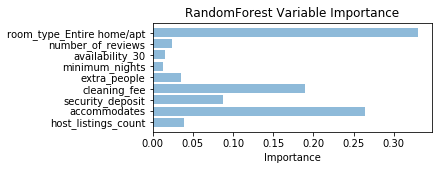

In [76]:
plt.figure(figsize=(5,2))
plt.barh(Xtr[list(Xtr.columns[(feature_idx)])].columns, airbnb_rf_final.named_steps.rf.feature_importances_,
        align='center', alpha=0.5)
plt.yticks(Xtr[list(Xtr.columns[(feature_idx)])].columns)
plt.xlabel('Importance')
plt.title('RandomForest Variable Importance')
plt.show()

#### 3.8 Predictions on the test set

In [77]:
Xts, yts = test.drop(["price"], axis=1), test.price

In [78]:
rf_pred_regress = airbnb_rf_final.predict(Xts[list(Xts.columns[(feature_idx)])])

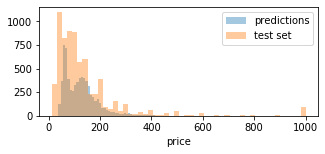

In [79]:
plt.figure(figsize=(5,2))
sns.distplot(np.exp(rf_pred_regress), label="predictions", kde=False)
sns.distplot(np.exp(yts), label="test set",kde=False)
plt.legend()

In [80]:
print('Mean Squared Error RF:', mean_squared_error(np.exp(yts),  np.exp(rf_pred_regress)))
print('Mean Squared Error RF:', mean_squared_error(yts, rf_pred_regress))

Mean Squared Error RF: 14423.912128665064
Mean Squared Error RF: 0.2566398018386507


In [ ]:
np.sqrt( mean_squared_error(np.exp(yts),  np.exp(rf_pred_regress)))